In [8]:
## This file tests the 2d Point mass QP code
## Author : Avadesh Meduri
## Date : 15/02/2021

import torch
from torch.nn import functional as F

import numpy as np
from matplotlib import pyplot as plt
from solver import quadprog_solve_qp
from twod_point_mass import TwoDPointMass

from diff_qp import DiffQP


In [2]:
problem = TwoDPointMass(20, 400)
wt = [1e-4,1e-4, 1e-4,1e-4, 1e-2, 1e-2]
wt_ter = [1e+4, 1e+4, 1e+5, 1e+5]

Q, q, A, b, G, h = problem.create_matrices([0,0,0,0], [-10,0,0,0], wt, wt_ter)

x,lag = quadprog_solve_qp(Q, q, G, h, A, b)

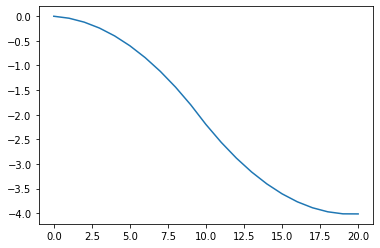

In [3]:
plt.plot(x[0::6])

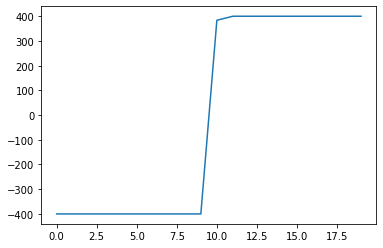

In [4]:
plt.plot(x[4::6])

In [5]:
def TerminalLoss(pred, des):
    
    A = torch.zeros((des.shape[0], des.shape[0]), dtype = torch.double)
    A[-4:, -4:] = torch.eye(4, dtype = torch.double)
    diff = pred - des
    return torch.matmul(torch.matmul(diff, A), diff)
    

In [9]:
class IOC(torch.nn.Module):
    
    def __init__(self, n_col, u_max):
        """
        this class tries to auto tune weights for a simple double integrator problem
        Input:
            n_col : number of collocation points
            u_max : torque limits on the double integrator
        """
        
        super(IOC, self).__init__()
        
        self.eps = 0.01
        
        problem = TwoDPointMass(n_col, u_max)
        self.A, self.b, self.G, self.h = problem.create_matrices_nn()
        
        self.Q = torch.zeros((6*n_col+4, 6*n_col+4, 6*n_col+4), dtype = float)
        self.R = self.eps * torch.eye(6*n_col+4)
        for i in range(6*n_col+4):
            self.Q[i,i,i] = 1.0
        
#         self.weight = torch.nn.Parameter(torch.rand(self.A.shape[1], self.A.shape[1], dtype = float))
        self.weight = torch.nn.Parameter(torch.rand(self.A.shape[1], dtype = float))

        self.x_nom = torch.nn.Parameter(torch.ones(self.A.shape[1], dtype = float))
        
    def forward(self, x_init):
        
        
#         self.Q_torch = 0.5*self.weight.mm(self.weight.t())
        tmp = F.relu(self.weight)
        self.Q_torch = 0.5*torch.matmul(self.Q, tmp) + self.R        
        q = -1 * torch.matmul(self.Q_torch, self.x_nom)

        # setting up the QP
        self.b[-4:] = x_init
        
        x_opt = DiffQP.apply(self.Q_torch, q, self.G, self.h, self.A, self.b)
        
        return x_opt

In [54]:
n_col = 15
u_max = 400
ioc = IOC(n_col, u_max)

lr = 5e+1
eps = 400
optimizer = torch.optim.Adam(ioc.parameters(), lr=lr)

x_init = [0, 0, 0, 0]
x_des = torch.zeros(6*n_col + 4)
x_des[-4:] = torch.tensor([2,-5,0,0])

for i in range(eps):
    
    x_pred = ioc(x_init) 
    
    loss = TerminalLoss(x_pred, x_des)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [55]:
x_pred = ioc(x_init) 
x_pred = x_pred.detach().numpy()

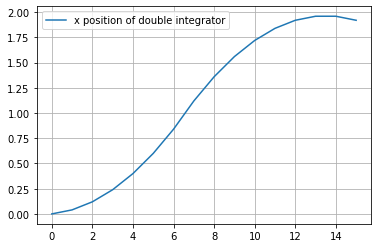

In [56]:
plt.plot(x_pred[0::6],label = "x position of double integrator")
plt.grid()
plt.legend()

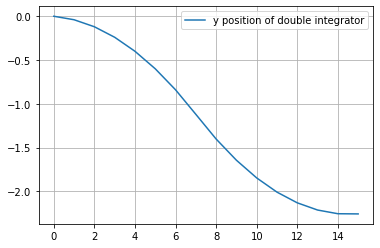

In [57]:
plt.plot(x_pred[1::6],label = "y position of double integrator")
plt.grid()
plt.legend()

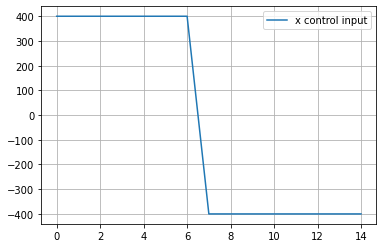

In [58]:
plt.plot(x_pred[4::6], label = "x control input")
plt.grid()
plt.legend()

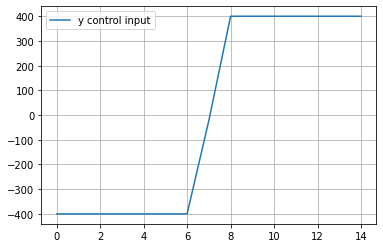

In [59]:
plt.plot(x_pred[5::6], label = "y control input")
plt.grid()
plt.legend()